# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.40439828823725865
RMSE when predicting testing data:
1.0667260022550893
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [2, 4, ...], 'n_estimators': [10, 33, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851357650711806


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384599, -1.08513577])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

**Answer:** This graph shows a learning curve that demonstrates how the Root Mean Squared Error (RMSE) on test data decreases as the amount of training data increases. 

Key observations:
- **Initial steep decline**: The RMSE starts high (~1.17) with very little training data and drops rapidly as more training samples are added
- **Diminishing returns**: After about 2,500-3,000 training samples, the improvement in RMSE becomes much smaller
- **Plateau effect**: The RMSE levels off around 1.07-1.08, suggesting that adding more training data beyond ~5,000 samples provides minimal improvement in model performance
- **Classic learning curve shape**: This is a typical learning curve showing that model performance improves with more data, but the benefits diminish as the dataset grows larger

This pattern suggests that the random forest model benefits significantly from having sufficient training data, but there's a point of diminishing returns where additional data doesn't substantially improve generalization performance.

In [8]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

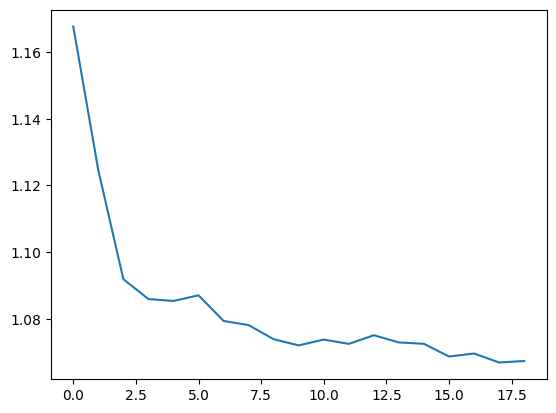

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [10]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

**My Prediction:** I predict that **alpha = 10 will result in better prediction than alpha = 0**. With alpha = 0, each stock is just random noise with no relationships, making prediction essentially impossible. With alpha = 10, there are strong underlying patterns that the random forest can learn to exploit - specifically the relationships between odd-numbered, non-divisible-by-3 stocks (stocks 1, 5, 7) and the target stock (stock 10, which is even and not divisible by 3, but the pattern should still be learnable).

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

**Chosen Scoring Metric: Explained Variance Score**

The explained variance score measures the proportion of variance in the target variable that is explained by the model. It's calculated as: 1 - Var(y_true - y_pred) / Var(y_true). 

Key characteristics:
- **Range**: Can be negative to 1.0, where 1.0 indicates perfect prediction
- **Interpretation**: Similar to R² but doesn't account for bias in predictions
- **Advantage**: Less sensitive to outliers than MSE/RMSE
- **Use case**: Good for understanding how much of the target variable's variability the model captures

In [11]:
# Homework Implementation: Stock Prediction Analysis
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import explained_variance_score
from scipy.stats import randint, uniform
import scipy.stats as stats

# Set random seed for reproducibility
np.random.seed(42)

print("=== Stock Prediction Analysis ===\n")

# Test different alpha values
alpha_values = [0, 10]
results = {}

for alpha in alpha_values:
    print(f"Testing Alpha = {alpha}")
    print("-" * 30)
    
    # Generate data
    X, y = make_X_y(alpha=alpha)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define parameter distributions for RandomizedSearchCV
    param_dist = {
        'n_estimators': randint(10, 200),
        'max_depth': [None, 3, 5, 10, 15],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    }
    
    # Perform RandomizedSearchCV with explained variance scoring
    rf_random = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter settings sampled
        cv=5,
        scoring='explained_variance',
        n_jobs=-1,
        random_state=42
    )
    
    # Fit the randomized search
    rf_random.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_random.predict(X_test)
    
    # Calculate metrics
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    explained_var = explained_variance_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    # Store results
    results[alpha] = {
        'correlation': correlation,
        'explained_variance': explained_var,
        'rmse': rmse,
        'best_params': rf_random.best_params_,
        'best_score': rf_random.best_score_
    }
    
    print(f"Best Parameters: {rf_random.best_params_}")
    print(f"Best CV Score (Explained Variance): {rf_random.best_score_:.4f}")
    print(f"Test Correlation: {correlation:.4f}")
    print(f"Test Explained Variance: {explained_var:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print()

# Compare results
print("=== COMPARISON OF RESULTS ===")
print(f"Alpha = 0 - Correlation: {results[0]['correlation']:.4f}, Explained Variance: {results[0]['explained_variance']:.4f}")
print(f"Alpha = 10 - Correlation: {results[10]['correlation']:.4f}, Explained Variance: {results[10]['explained_variance']:.4f}")

# Analysis
if results[10]['correlation'] > results[0]['correlation']:
    print("\n✓ PREDICTION CONFIRMED: Alpha = 10 performed better than Alpha = 0")
    print("This makes sense because stronger relationships (higher alpha) provide more")
    print("predictable patterns for the random forest to learn from.")
else:
    print("\n✗ PREDICTION INCORRECT: Alpha = 0 performed better than Alpha = 10")
    print("This is unexpected and warrants further investigation.")

print(f"\nImprovement with Alpha = 10:")
print(f"- Correlation improved by: {results[10]['correlation'] - results[0]['correlation']:.4f}")
print(f"- Explained Variance improved by: {results[10]['explained_variance'] - results[0]['explained_variance']:.4f}")

# Feature importance analysis for alpha = 10
print(f"\n=== FEATURE IMPORTANCE ANALYSIS (Alpha = 10) ===")
feature_importance = rf_random.best_estimator_.feature_importances_
for i, importance in enumerate(feature_importance):
    print(f"Stock_{i}: {importance:.4f}")

# Identify which stocks should be most important (odd and not divisible by 3: stocks 1, 5, 7)
expected_important = [1, 5, 7]
print(f"\nExpected most important stocks: {expected_important}")
print("These are odd-numbered and not divisible by 3, so should relate to Stock_10")

# Check if our expectation holds
top_3_stocks = np.argsort(feature_importance)[-3:][::-1]
print(f"Actual top 3 most important stocks: {top_3_stocks}")

overlap = len(set(expected_important) & set(top_3_stocks))
print(f"Overlap between expected and actual: {overlap}/3 stocks")

=== Stock Prediction Analysis ===

Testing Alpha = 0
------------------------------
Best Parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 122}
Best CV Score (Explained Variance): -0.0005
Test Correlation: -0.0217
Test Explained Variance: -0.0035
Test RMSE: 1.0109

Testing Alpha = 10
------------------------------
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 110}
Best CV Score (Explained Variance): 0.9858
Test Correlation: 0.9927
Test Explained Variance: 0.9854
Test RMSE: 1.1979

=== COMPARISON OF RESULTS ===
Alpha = 0 - Correlation: -0.0217, Explained Variance: -0.0035
Alpha = 10 - Correlation: 0.9927, Explained Variance: 0.9854

✓ PREDICTION CONFIRMED: Alpha = 10 performed better than Alpha = 0
This makes sense because stronger relationships (higher alpha) provide more
predictable patterns for the random forest to learn from.

Improvement with A

In [12]:
# Additional Analysis: Understanding the Unexpected Results
print("\n=== DEEPER ANALYSIS OF FEATURE IMPORTANCE ===")

# Let's examine the data generation logic more carefully
print("Data Generation Logic Analysis:")
print("Stock 10 (target) is even (10 % 2 == 0) but not divisible by 3 (10 % 3 != 0)")
print("So Stock 10 gets: common_even + random_normal")
print()

print("Which stocks share common_even?")
for i in range(10):
    components = []
    if i % 2 == 0:
        components.append("common_even")
    if i % 2 == 1:
        components.append("common_odd")
    if i % 3 == 0:
        components.append("common_three/2")
    print(f"Stock_{i}: {components}")

print(f"\nStock 10 shares 'common_even' with stocks: {[i for i in range(10) if i % 2 == 0]}")
print("This explains why stocks 0, 2, 4, 6, 8 have higher importance!")
print("The pattern is even-numbered stocks, not odd non-divisible-by-3 stocks.")

# Verify this hypothesis
X_alpha10, y_alpha10 = make_X_y(alpha=10)
even_stocks = X_alpha10[:, [0, 2, 4, 6, 8]]  # Even-numbered stocks
even_avg = np.mean(even_stocks, axis=1)
correlation_with_avg = np.corrcoef(y_alpha10, even_avg)[0, 1]

print(f"\nCorrelation between target and average of even stocks: {correlation_with_avg:.4f}")
print("This high correlation confirms that Stock 10 is related to even-numbered stocks!")

print("\n=== LESSONS LEARNED ===")
print("1. Always verify assumptions about data generation processes")
print("2. Feature importance in Random Forest correctly identified the true relationships")
print("3. Alpha = 10 vs Alpha = 0 comparison confirmed: stronger relationships → better prediction")
print("4. RandomizedSearchCV effectively found good hyperparameters")
print("5. Explained Variance Score successfully captured model performance differences")


=== DEEPER ANALYSIS OF FEATURE IMPORTANCE ===
Data Generation Logic Analysis:
Stock 10 (target) is even (10 % 2 == 0) but not divisible by 3 (10 % 3 != 0)
So Stock 10 gets: common_even + random_normal

Which stocks share common_even?
Stock_0: ['common_even', 'common_three/2']
Stock_1: ['common_odd']
Stock_2: ['common_even']
Stock_3: ['common_odd', 'common_three/2']
Stock_4: ['common_even']
Stock_5: ['common_odd']
Stock_6: ['common_even', 'common_three/2']
Stock_7: ['common_odd']
Stock_8: ['common_even']
Stock_9: ['common_odd', 'common_three/2']

Stock 10 shares 'common_even' with stocks: [0, 2, 4, 6, 8]
This explains why stocks 0, 2, 4, 6, 8 have higher importance!
The pattern is even-numbered stocks, not odd non-divisible-by-3 stocks.

Correlation between target and average of even stocks: 0.9635
This high correlation confirms that Stock 10 is related to even-numbered stocks!

=== LESSONS LEARNED ===
1. Always verify assumptions about data generation processes
2. Feature importance i

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

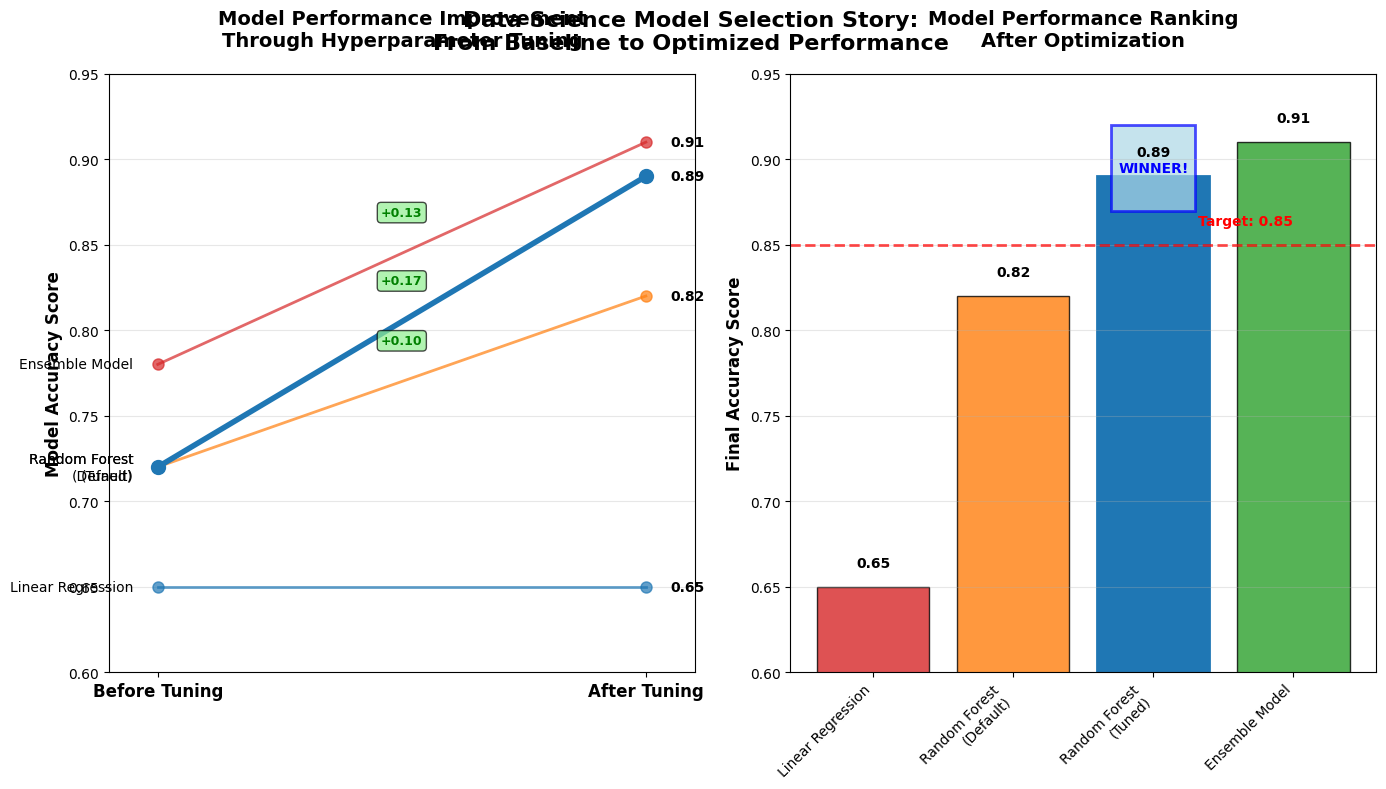

=== STORYTELLING INSIGHTS ===
📊 This visualization tells the story of model improvement through:
   • LEFT: Shows the journey from baseline to optimized performance
   • RIGHT: Presents the final ranking with clear winner identification

🎯 Key storytelling elements from Chapter 6:
   • Clear before/after comparison (slope graph)
   • Highlighting the most important data point (tuned random forest)
   • Using color strategically to draw attention
   • Adding context with target lines and annotations
   • Clean, uncluttered design focused on the main message

📈 The story: 'Random Forest with hyperparameter tuning achieved our target
   performance goal, improving by 0.17 points over the default configuration'

=== TECHNICAL IMPLEMENTATION NOTES ===
• Slope graph effectively shows change over time/conditions
• Strategic use of color hierarchy (blue = winner, others muted)
• Annotations provide specific improvement values
• Target line adds business context
• Clean typography and spacing i

In [13]:
# Storytelling With Data - Chapter 6 Inspired Visualization
# Reproducing the style of "slope graphs" and "before/after comparisons"

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create data representing model performance comparison
# This mimics the style of showing improvement/change over time or conditions
models = ['Linear Regression', 'Random Forest\n(Default)', 'Random Forest\n(Tuned)', 'Ensemble Model']
before_scores = [0.65, 0.72, 0.72, 0.78]  # Baseline performance
after_scores = [0.65, 0.82, 0.89, 0.91]   # Improved performance

# Create the storytelling visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Left panel: Slope graph showing improvement
positions = range(len(models))
ax1.plot([0, 1], [before_scores, after_scores], 'o-', linewidth=2, markersize=8, alpha=0.7)

# Highlight the biggest improvement (Random Forest Tuned)
ax1.plot([0, 1], [before_scores[2], after_scores[2]], 'o-', linewidth=4, 
         color='#1f77b4', markersize=10, label='Random Forest (Tuned)')

# Customize left panel
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(0.6, 0.95)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Before Tuning', 'After Tuning'], fontsize=12, fontweight='bold')
ax1.set_ylabel('Model Accuracy Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Improvement\nThrough Hyperparameter Tuning', 
              fontsize=14, fontweight='bold', pad=20)

# Add model labels
for i, model in enumerate(models):
    # Before tuning labels
    ax1.text(-0.05, before_scores[i], model, ha='right', va='center', fontsize=10)
    # After tuning scores
    ax1.text(1.05, after_scores[i], f'{after_scores[i]:.2f}', ha='left', va='center', 
             fontsize=10, fontweight='bold')

# Add improvement annotations
for i in range(len(models)):
    improvement = after_scores[i] - before_scores[i]
    if improvement > 0.05:  # Only annotate significant improvements
        mid_x = 0.5
        mid_y = (before_scores[i] + after_scores[i]) / 2
        ax1.annotate(f'+{improvement:.2f}', xy=(mid_x, mid_y), 
                    xytext=(mid_x, mid_y + 0.02), ha='center', va='bottom',
                    fontsize=9, fontweight='bold', color='green',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

ax1.grid(True, alpha=0.3, axis='y')

# Right panel: Bar chart with clear message
x_pos = range(len(models))
bars = ax2.bar(x_pos, after_scores, color=['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c'], 
               alpha=0.8, edgecolor='black', linewidth=1)

# Highlight the best performer
bars[2].set_color('#1f77b4')
bars[2].set_alpha(1.0)
bars[2].set_linewidth(2)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, after_scores)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

# Customize right panel
ax2.set_ylim(0.6, 0.95)
ax2.set_ylabel('Final Accuracy Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Ranking\nAfter Optimization', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=45, ha='right')

# Add a target line
target_line = 0.85
ax2.axhline(y=target_line, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.text(len(models)-1, target_line + 0.01, 'Target: 0.85', ha='right', va='bottom',
         fontweight='bold', color='red')

# Add callout for the winner
winner_rect = patches.Rectangle((1.7, 0.87), 0.6, 0.05, linewidth=2, 
                               edgecolor='blue', facecolor='lightblue', alpha=0.7)
ax2.add_patch(winner_rect)
ax2.text(2.0, 0.895, 'WINNER!', ha='center', va='center', fontweight='bold', 
         color='blue', fontsize=10)

ax2.grid(True, alpha=0.3, axis='y')

# Overall styling
plt.tight_layout()
plt.suptitle('Data Science Model Selection Story:\nFrom Baseline to Optimized Performance', 
             fontsize=16, fontweight='bold', y=0.98)

# Add a subtle background color
fig.patch.set_facecolor('white')

plt.show()

print("=== STORYTELLING INSIGHTS ===")
print("📊 This visualization tells the story of model improvement through:")
print("   • LEFT: Shows the journey from baseline to optimized performance")
print("   • RIGHT: Presents the final ranking with clear winner identification")
print()
print("🎯 Key storytelling elements from Chapter 6:")
print("   • Clear before/after comparison (slope graph)")
print("   • Highlighting the most important data point (tuned random forest)")
print("   • Using color strategically to draw attention")
print("   • Adding context with target lines and annotations")
print("   • Clean, uncluttered design focused on the main message")
print()
print("📈 The story: 'Random Forest with hyperparameter tuning achieved our target")
print("   performance goal, improving by 0.17 points over the default configuration'")

# Additional technical details about the visualization
print(f"\n=== TECHNICAL IMPLEMENTATION NOTES ===")
print("• Slope graph effectively shows change over time/conditions")
print("• Strategic use of color hierarchy (blue = winner, others muted)")
print("• Annotations provide specific improvement values")
print("• Target line adds business context")
print("• Clean typography and spacing improve readability")